Loaded image from: /content/baboon_256.png
Image shape (H, W, C): (256, 256, 3)


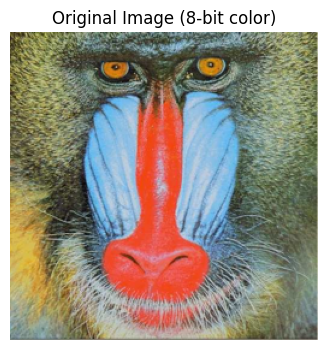

Number of pixels: 65536

=== Running K-means with K = 2 colors ===
Finished K = 2: MSE = 1456.94, rate = 1.00 bits/pixel
Saved quantized image with K=2 colors to: /content/baboon_k2.png

=== Running K-means with K = 8 colors ===
Finished K = 8: MSE = 277.30, rate = 3.00 bits/pixel
Saved quantized image with K=8 colors to: /content/baboon_k8.png

=== Running K-means with K = 16 colors ===
Finished K = 16: MSE = 144.59, rate = 4.00 bits/pixel
Saved quantized image with K=16 colors to: /content/baboon_k16.png


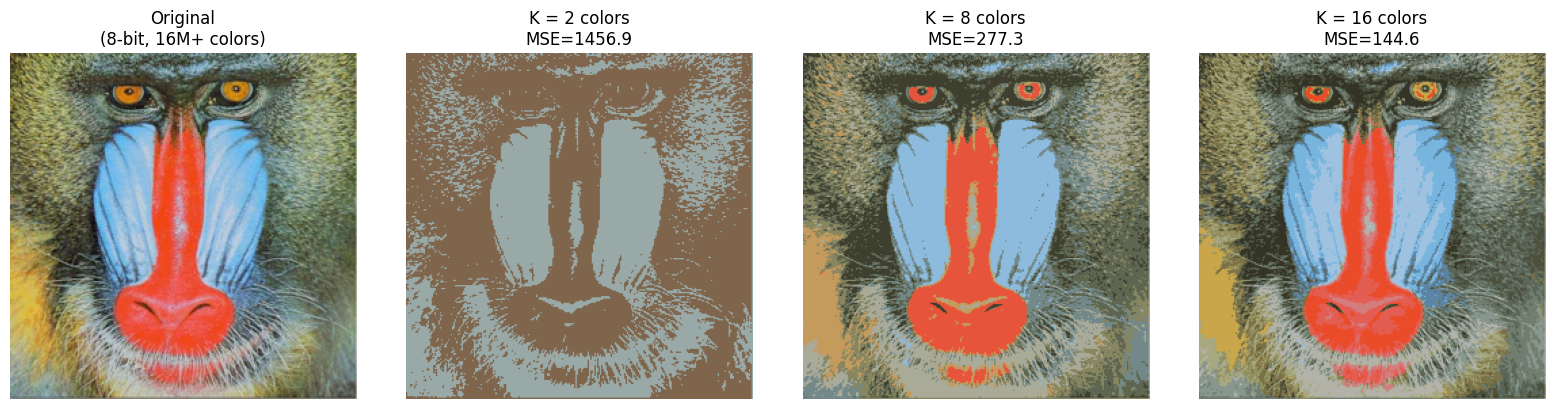

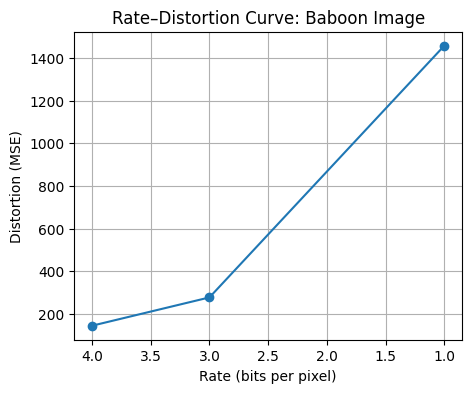


===== SUMMARY: Rate–Distortion Results =====
K (colors)	Bits/pixel	MSE
2        	1.00		1456.94
8        	3.00		277.30
16       	4.00		144.59

You can insert the saved images (baboon_k2.png, baboon_k8.png, baboon_k16.png) into your report/slides as visual examples of rate–distortion quantization.


In [3]:
# ===============================================================
# K-means clustering–based rate–distortion quantization
# Image: /content/baboon_256.png  (256 x 256, RGB)
# ===============================================================

import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from PIL import Image
import math

# -----------------------------
# 1. LOAD IMAGE
# -----------------------------
image_path = "/content/baboon_256.png"   # <-- make sure this exists in Colab

# Open image and ensure RGB format
img = Image.open(image_path).convert("RGB")
img_np = np.array(img)   # shape (H, W, 3)

print(f"Loaded image from: {image_path}")
print(f"Image shape (H, W, C): {img_np.shape}")

# Display original image
plt.figure(figsize=(4,4))
plt.imshow(img_np)
plt.axis("off")
plt.title("Original Image (8-bit color)")
plt.show()

# -----------------------------
# 2. PREPARE DATA FOR K-MEANS
# -----------------------------
H, W, C = img_np.shape
pixels = img_np.reshape(-1, 3).astype(np.float32)   # shape (H*W, 3)
print(f"Number of pixels: {pixels.shape[0]}")

# -----------------------------
# 3. DEFINE K-MEANS QUANTIZATION FUNCTION
# -----------------------------
def kmeans_quantize(image_np, K, max_iter=50):
    """
    Perform K-means color quantization on an RGB image.

    image_np : numpy array of shape (H, W, 3), dtype uint8
    K        : number of colors (clusters)
    max_iter : KMeans maximum iterations
    """
    H, W, C = image_np.shape
    pixels = image_np.reshape(-1, 3).astype(np.float32)

    # Run K-means in RGB space
    print(f"\n=== Running K-means with K = {K} colors ===")
    kmeans = KMeans(
        n_clusters=K,
        random_state=0,
        n_init=5,          # number of initializations
        max_iter=max_iter  # maximum iterations
    )
    labels = kmeans.fit_predict(pixels)     # cluster index for each pixel
    centers = kmeans.cluster_centers_       # RGB values of cluster centers

    # Map each pixel to its cluster center (quantized color)
    quantized_pixels = centers[labels].astype(np.uint8)
    quantized_img = quantized_pixels.reshape(H, W, 3)

    # Compute distortion: Mean Squared Error between original and quantized image
    diff = image_np.astype(np.float32) - quantized_img.astype(np.float32)
    mse = np.mean(diff ** 2)

    # Rate: bits per pixel needed for color index
    rate_bpp = math.log2(K)

    print(f"Finished K = {K}: MSE = {mse:.2f}, rate = {rate_bpp:.2f} bits/pixel")
    return quantized_img, mse, rate_bpp

# -----------------------------
# 4. RUN QUANTIZATION FOR MULTIPLE K VALUES
# -----------------------------
# K=2 (1-bit), K=8 (3-bit), K=16 (4-bit) – change this list as needed
K_VALUES = [2, 8, 16]

results = {}  # store results for later plots

for K in K_VALUES:
    q_img, mse, rate = kmeans_quantize(img_np, K)
    results[K] = {"image": q_img, "mse": mse, "rate": rate}

    # Save quantized image
    out_path = f"/content/baboon_k{K}.png"
    Image.fromarray(q_img).save(out_path)
    print(f"Saved quantized image with K={K} colors to: {out_path}")

# -----------------------------
# 5. SHOW ORIGINAL + QUANTIZED IMAGES SIDE BY SIDE
# -----------------------------
n_cols = len(K_VALUES) + 1
plt.figure(figsize=(4*n_cols, 4))

# Original
plt.subplot(1, n_cols, 1)
plt.imshow(img_np)
plt.axis("off")
plt.title("Original\n(8-bit, 16M+ colors)")

# Quantized
for i, K in enumerate(K_VALUES, start=2):
    plt.subplot(1, n_cols, i)
    plt.imshow(results[K]["image"])
    plt.axis("off")
    plt.title(f"K = {K} colors\nMSE={results[K]['mse']:.1f}")

plt.tight_layout()
plt.show()

# -----------------------------
# 6. PLOT RATE–DISTORTION CURVE
# -----------------------------
rates = [results[K]["rate"] for K in K_VALUES]
mses  = [results[K]["mse"]  for K in K_VALUES]

plt.figure(figsize=(5,4))
plt.plot(rates, mses, marker="o")
plt.xlabel("Rate (bits per pixel)")
plt.ylabel("Distortion (MSE)")
plt.title("Rate–Distortion Curve: Baboon Image")
plt.grid(True)
plt.gca().invert_xaxis()  # optional: higher rate on left, lower on right
plt.show()

# -----------------------------
# 7. PRINT SUMMARY TABLE
# -----------------------------
print("\n===== SUMMARY: Rate–Distortion Results =====")
print("K (colors)\tBits/pixel\tMSE")
for K in K_VALUES:
    print(f"{K:<9}\t{results[K]['rate']:.2f}\t\t{results[K]['mse']:.2f}")

print("\nYou can insert the saved images (baboon_k2.png, baboon_k8.png, "
      "baboon_k16.png) into your report/slides as visual examples of "
      "rate–distortion quantization.")
